# Compare similar flights to each other

In [1]:
## First import general packages for running python analysis:
import os, h5py, datetime,pytz
import numpy as np
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
import pickle, glob

from scipy.interpolate import griddata
import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from scipy.optimize import least_squares

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

## Then import the beamcals module packages and initialize 'gbosite' class:
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
from beamcals.sites import site
gbosite=site.site('../beamcals/beamcals/sites/GBO_config.npz')

# various gridding attempts
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

freqs = 800.0*np.ones(1024) + (-400/1024.)*np.arange(1024)


In [2]:

class dict_to_class:
    def __init__(self,dictionary):
        for key in dictionary.keys():
            setattr(self,key,dictionary[key])

class dict_to_class_cut:
    def __init__(self,dictionary):
        for key in dictionary.keys():
            if 'bg' not in key or 'sub' in key:
                setattr(self,key,dictionary[key])
def get_newpointing(x,y,xc,yx,theta):
    xp = x - xc
    yp = y - yc
    xpp = np.cos(theta)*xp - np.sin(theta)*yp
    ypp = np.sin(theta)*xp + np.cos(theta)*yp
    return xpp, ypp

def get_slice(x,y,ty,val,tol):
    if ty=='x':
        ni = np.where(np.abs(x-val)<=tol)
    if ty=='y':
        ni = np.where(np.abs(y-val)<=tol)
    return ni

def radial_profile(x,y,z,x0,y0):
    r = np.sqrt((x-x0)**2 + (y-y0)**2)
    r = r.astype(np.int)

    tbin = np.bincount(r.ravel(), z.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile 

In [6]:
## Define anything I want to keep common
dotsize=1
freq_i = 900
res = 500
fitdir = '/hirax/GBO_Analysis_Outputs/main_beam_fits/'
LX,LY = np.meshgrid(np.linspace(-100,100,res), np.linspace(-100,100,res))
X = np.arange(-100,100,2.0,dtype='float64')
Y = np.arange(-100,100,2.0,dtype='float64')
d=0

## PLAYING AROUND AREA ####

In [4]:
## This is the code to keep two flights in memory, to try to extract some useful statistics

In [23]:
## USE THIS ONLY IF YOU NEED TO KEEP THE AMP CORRECTED DATA SEPARATE, for example for adding together 
# Flight 534 and 535

# main beam fitting for this flight - look at params
fitdir = '/hirax/GBO_Analysis_Outputs/main_beam_fits/'
flyfiles=['FLY534_20210826T185621Z_ver_20230208T122919_2dGauss_and_Airy_Params.npz',
          'FLY535_20210826T192056Z_ver_20230208T124740_2dGauss_and_Airy_Params.npz']


# indexign is a kluge for now
fits0 = np.load(fitdir+flyfiles[0])
fits1 = np.load(fitdir+flyfiles[1])


keys826 = [entry.split('dicts/')[1].split('.')[0] for entry in glob.glob('/hirax/GBO_Aug_2021/TONE_ACQ/flight_dicts/*')]
keys826.sort()

dict826 = {}

for key in ['20210826T185632Z','20210826T192108Z']:
    with open('/hirax/GBO_Aug_2021/TONE_ACQ/flight_dicts/'+key+'.pkl', 'rb') as f:
        loaded_dict = pickle.load(f)
    dict826[key] = dict_to_class_cut(loaded_dict)
    print(key)


ks = [3,4]

for k_i in ks:
    k = keys826[k_i]
    print(keys826[k_i])
    
    if k_i==3:
        # x, y : this will be the common for all data in this flight
        ## Find indices with noise source on, not nan
        inds_on_cut=np.intersect1d(np.arange(len(dict826[k].t_arr_datetime)),dict826[k].inds_on).tolist()
        indsuse0 = [j for j in inds_on_cut if str(dict826[k].drone_xyz_LC_interp[j,0]) != 'nan']
        x0 = dict826[k].drone_xyz_LC_interp[indsuse0,0]
        y0 = dict826[k].drone_xyz_LC_interp[indsuse0,1]
    else: 
        inds_on_cut=np.intersect1d(np.arange(len(dict826[k].t_arr_datetime)),dict826[k].inds_on).tolist()
        indsuse1 = [j for j in inds_on_cut if str(dict826[k].drone_xyz_LC_interp[j,0]) != 'nan']
        x1 = dict826[k].drone_xyz_LC_interp[indsuse1,0]
        y1 = dict826[k].drone_xyz_LC_interp[indsuse1,1]



20210826T185632Z
20210826T192108Z
20210826T185632Z
20210826T192108Z


In [30]:
zstar.shape

(100, 100)

20210826T185632Z 20210826T185632Z


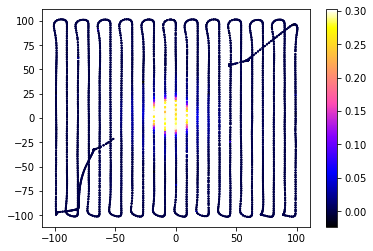

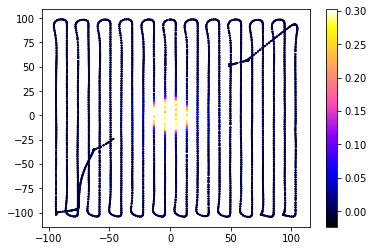

<ipython-input-33-4890b3de8696>:40: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(xp,yp,s=dotsize, c=10*np.log10(amp_corr), cmap='gnuplot2')
<ipython-input-33-4890b3de8696>:40: RuntimeWarning: invalid value encountered in log10
  plt.scatter(xp,yp,s=dotsize, c=10*np.log10(amp_corr), cmap='gnuplot2')


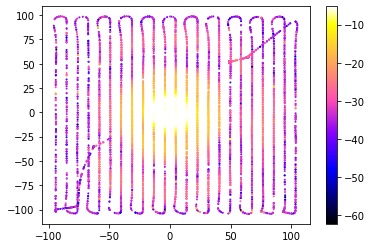

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 0.0009021120839710425
Full Sill: 0.0009042126736688273
Range: 33.58391866138239
Nugget: 2.100589697784692e-06 



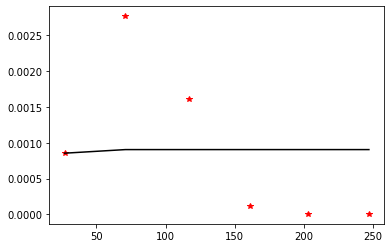

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...

20210826T192108Z 20210826T192108Z


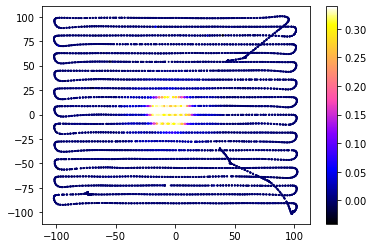

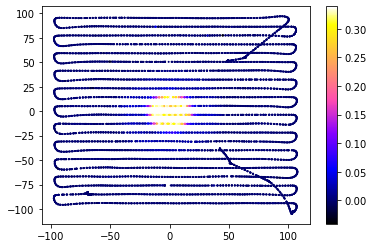

<ipython-input-33-4890b3de8696>:40: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(xp,yp,s=dotsize, c=10*np.log10(amp_corr), cmap='gnuplot2')
<ipython-input-33-4890b3de8696>:40: RuntimeWarning: invalid value encountered in log10
  plt.scatter(xp,yp,s=dotsize, c=10*np.log10(amp_corr), cmap='gnuplot2')


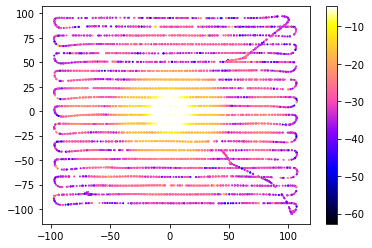

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 0.0010635035368350273
Full Sill: 0.0010665927459709709
Range: 37.58068338886474
Nugget: 3.0892091359436487e-06 



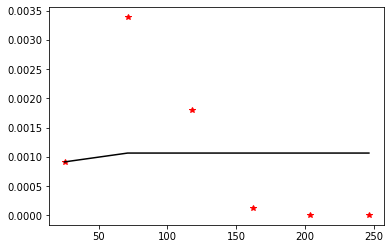

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



No handles with labels found to put in legend.


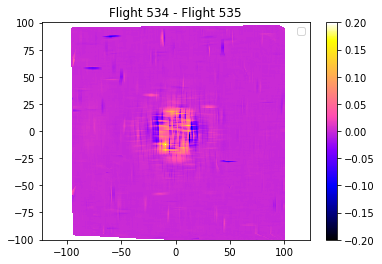

<ipython-input-33-4890b3de8696>:58: RuntimeWarning: invalid value encountered in log10
  plt.pcolormesh(LX, LY, 10*np.log10(LZs[1,:,:])- 10*np.log(LZs[0,:,:]), shading='auto',cmap='gnuplot2',vmin=-40,vmax=40)
<ipython-input-33-4890b3de8696>:58: RuntimeWarning: invalid value encountered in log
  plt.pcolormesh(LX, LY, 10*np.log10(LZs[1,:,:])- 10*np.log(LZs[0,:,:]), shading='auto',cmap='gnuplot2',vmin=-40,vmax=40)
No handles with labels found to put in legend.


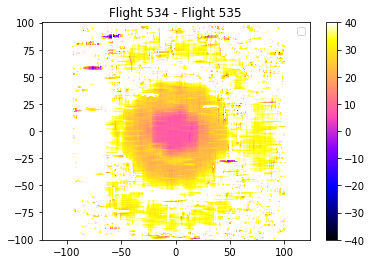

No handles with labels found to put in legend.


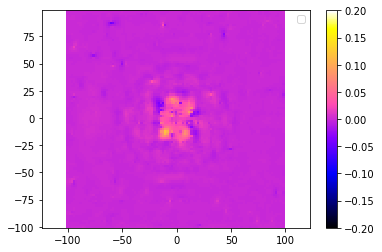

<ipython-input-33-4890b3de8696>:73: RuntimeWarning: invalid value encountered in log10
  plt.pcolormesh(X, Y, 10*np.log10(zstars[1,:,:]) - 10*np.log10(zstars[0,:,:]), shading='auto', cmap='gnuplot2',vmin=-40,vmax=40)
No handles with labels found to put in legend.


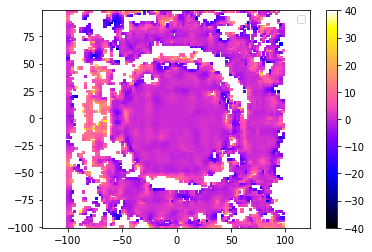

<ipython-input-2-889b832bb956>:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  r = r.astype(np.int)
<ipython-input-2-889b832bb956>:31: RuntimeWarning: invalid value encountered in true_divide
  radialprofile = tbin / nr


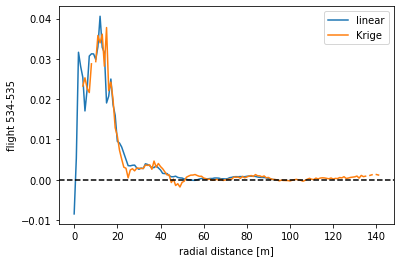

<ipython-input-2-889b832bb956>:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  r = r.astype(np.int)
<ipython-input-2-889b832bb956>:31: RuntimeWarning: invalid value encountered in true_divide
  radialprofile = tbin / nr


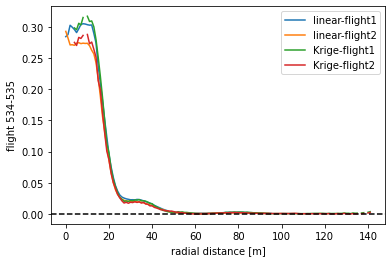

In [33]:
LZs = np.zeros([2,len(LZ[:,0]),len(LZ[0,:])])
zstars = np.zeros([2,len(X),len(Y)])

for d in [0]:
    for freq_i in [900]:
        for k_i in ks:
            k = keys826[k_i]
            print(k, keys826[k_i])
            if k_i==3:
                it = 0
                z = dict826[k].V_bgsub[indsuse0,freq_i,d]
                theta = 0#fits['G_popt'][d,freq_i,5]
                xc = fits0['G_popt'][d,freq_i,1]
                yc = fits0['G_popt'][d,freq_i,3]
                amp = fits0['G_popt'][d,freq_i,0]
                x = x0
                y = y0
                amp_corr = dict826[k].V_bgsub[indsuse0,freq_i,d]/amp
            else:
                it = 1
                z = dict826[k].V_bgsub[indsuse1,freq_i,d]
                theta = 0#fits['G_popt'][d,freq_i,5]
                xc = fits1['G_popt'][d,freq_i,1]
                yc = fits1['G_popt'][d,freq_i,3]
                amp = fits1['G_popt'][d,freq_i,0]
                x = x1
                y = y1
                amp_corr = dict826[k].V_bgsub[indsuse1,freq_i,d]/amp
                
                
            plt.scatter(x,y,s=dotsize, c=amp_corr, cmap='gnuplot2')
            plt.colorbar()
            plt.show()  

            xp,yp = get_newpointing(x,y,xc,yc,theta)       
            plt.scatter(xp,yp,s=dotsize, c=amp_corr, cmap='gnuplot2')
            plt.colorbar()
            plt.show()
       
            plt.scatter(xp,yp,s=dotsize, c=10*np.log10(amp_corr), cmap='gnuplot2')
            plt.colorbar()
            plt.show()

            # linear gridding, for reference
            LZs[it,:,:] = griddata((xp,yp), amp_corr, (LX,LY), method='linear')

            OK = OrdinaryKriging(xp,yp,amp_corr,variogram_model='spherical',verbose=True,enable_plotting=True)
            zstars[it,:,:],ss = OK.execute("grid",X,Y)

        ## Difference the two griddings - linear gridding
        plt.pcolormesh(LX, LY, LZs[1,:,:] - LZs[0,:,:], shading='auto',cmap='gnuplot2',vmin=-0.2,vmax=0.2)
        plt.legend()
        plt.colorbar()
        plt.axis("equal")
        plt.title('Flight 534 - Flight 535')
        plt.show()

        plt.pcolormesh(LX, LY, 10*np.log10(LZs[1,:,:])- 10*np.log(LZs[0,:,:]), shading='auto',cmap='gnuplot2',vmin=-40,vmax=40)
        plt.legend()
        plt.colorbar()
        plt.axis("equal")
        plt.title('Flight 534 - Flight 535')
        plt.show()

        ## difference two griddings - Krige
        plt.pcolormesh(X, Y, zstars[1,:,:]-zstars[0,:,:], shading='auto',cmap='gnuplot2',vmin=-0.2,vmax=0.2)
        plt.legend()
        plt.colorbar()
        plt.axis("equal")
        plt.show()


        plt.pcolormesh(X, Y, 10*np.log10(zstars[1,:,:]) - 10*np.log10(zstars[0,:,:]), shading='auto', cmap='gnuplot2',vmin=-40,vmax=40)
        plt.legend()
        plt.colorbar()
        plt.axis("equal")
        plt.show()

        rrX,rrY = np.meshgrid(X,Y)

        rp = radial_profile(LX,LY,LZs[1,:,:] - LZs[0,:,:],0,0)
        rp2 = radial_profile(rrX,rrY,zstars[1,:,:]-zstars[0,:,:],0,0)
        plt.plot(rp,label='linear')
        plt.plot(rp2,label='Krige')
        plt.axhline(0.0,linestyle='--',color='k')
        plt.xlabel('radial distance [m]')
        plt.ylabel('flight 534-535')
        plt.legend()
        plt.show()

        rp4 = radial_profile(LX,LY,LZs[1,:,:],0,0)
        rp5 = radial_profile(LX,LY,LZs[0,:,:],0,0)
        rp6 = radial_profile(rrX,rrY,zstars[1,:,:],0,0)
        rp7 = radial_profile(rrX,rrY,zstars[0,:,:],0,0)
        plt.plot(rp4,label='linear-flight1')
        plt.plot(rp5,label='linear-flight2')
        plt.plot(rp6,label='Krige-flight1')
        plt.plot(rp7,label='Krige-flight2')
        plt.axhline(0.0,linestyle='--',color='k')
        plt.xlabel('radial distance [m]')
        plt.ylabel('flight 534-535')
        plt.legend()
        plt.show()



20210826T192108Z
20210826T192108Z


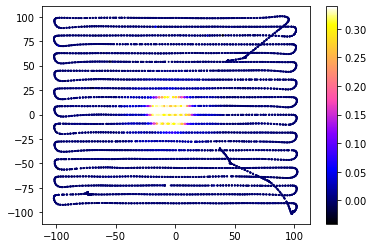

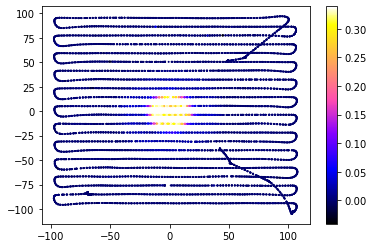

No handles with labels found to put in legend.


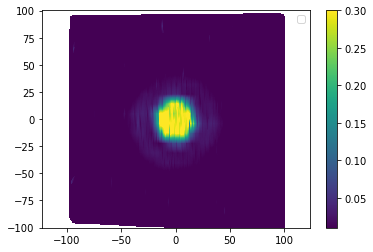

<ipython-input-8-c906117c2254>:59: RuntimeWarning: invalid value encountered in log10
  plt.pcolormesh(LX,LY, 10*np.log10(LZ_2), shading='auto',cmap='gnuplot2',vmin=0,vmax=-60)
No handles with labels found to put in legend.


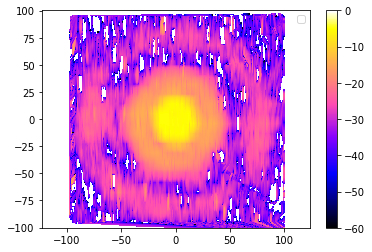

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 0.0010635035368350273
Full Sill: 0.0010665927459709709
Range: 37.58068338886474
Nugget: 3.0892091359436487e-06 



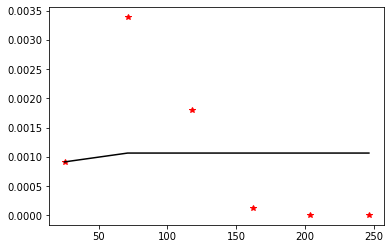

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



No handles with labels found to put in legend.


(100, 100) 100 100


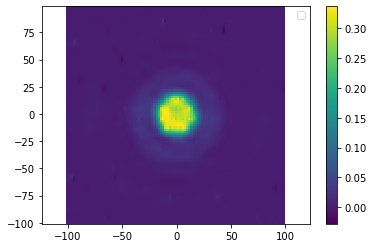

<ipython-input-8-c906117c2254>:77: RuntimeWarning: invalid value encountered in log10
  plt.pcolormesh(X, Y, 10*np.log10(zstar_2), shading='auto', cmap='gnuplot2',vmin=0,vmax=-60)
No handles with labels found to put in legend.


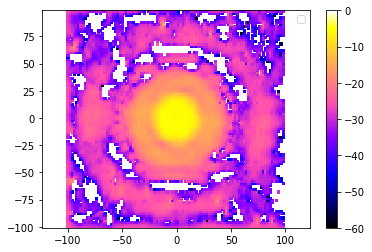

No handles with labels found to put in legend.


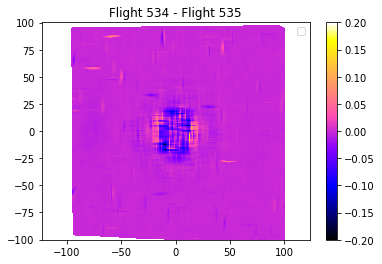

<ipython-input-11-8ea2ca82bf4a>:10: RuntimeWarning: invalid value encountered in log10
  plt.pcolormesh(LX, LY, 10*np.log10(LZ)- 10*np.log(LZ_2), shading='auto',cmap='gnuplot2',vmin=-40,vmax=40)
<ipython-input-11-8ea2ca82bf4a>:10: RuntimeWarning: invalid value encountered in log
  plt.pcolormesh(LX, LY, 10*np.log10(LZ)- 10*np.log(LZ_2), shading='auto',cmap='gnuplot2',vmin=-40,vmax=40)
No handles with labels found to put in legend.


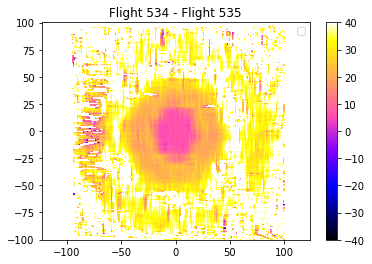

No handles with labels found to put in legend.


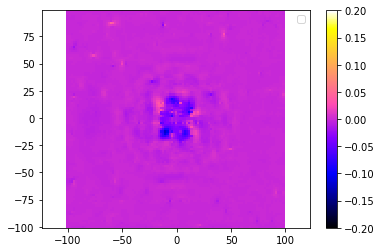

<ipython-input-11-8ea2ca82bf4a>:25: RuntimeWarning: invalid value encountered in log10
  plt.pcolormesh(X, Y, 10*np.log10(zstar) - 10*np.log10(zstar_2), shading='auto', cmap='gnuplot2',vmin=-40,vmax=40)
No handles with labels found to put in legend.


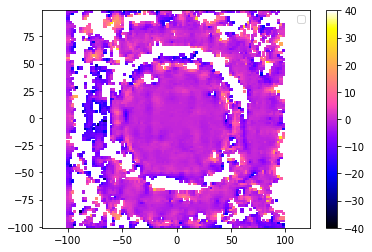

<ipython-input-2-889b832bb956>:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  r = r.astype(np.int)
<ipython-input-2-889b832bb956>:31: RuntimeWarning: invalid value encountered in true_divide
  radialprofile = tbin / nr


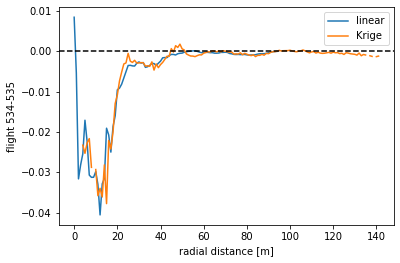

<ipython-input-2-889b832bb956>:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  r = r.astype(np.int)
<ipython-input-2-889b832bb956>:31: RuntimeWarning: invalid value encountered in true_divide
  radialprofile = tbin / nr


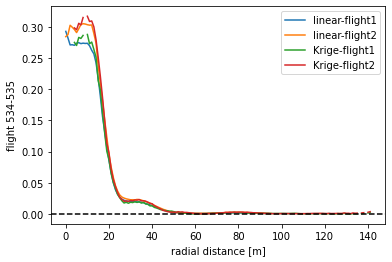

<ipython-input-2-889b832bb956>:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  r = r.astype(np.int)
<ipython-input-2-889b832bb956>:31: RuntimeWarning: invalid value encountered in true_divide
  radialprofile = tbin / nr


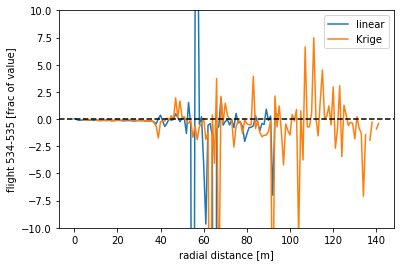

In [ ]:
### Below is the code for one flight at a time

20210826T185632Z
20210826T185632Z


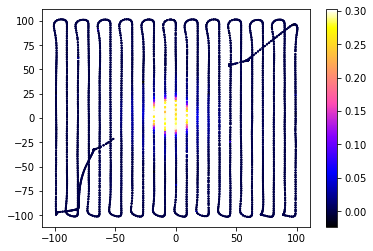

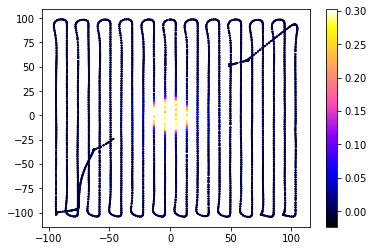

<ipython-input-4-1c0417f52169>:52: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(xp,yp,s=dotsize, c=10*np.log10(amp_corr), cmap='gnuplot2')
<ipython-input-4-1c0417f52169>:52: RuntimeWarning: invalid value encountered in log10
  plt.scatter(xp,yp,s=dotsize, c=10*np.log10(amp_corr), cmap='gnuplot2')


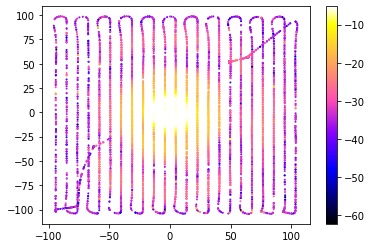

No handles with labels found to put in legend.


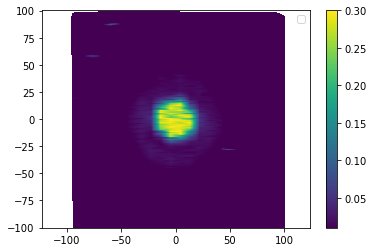

<ipython-input-4-1c0417f52169>:65: RuntimeWarning: invalid value encountered in log10
  plt.pcolormesh(LX,LY, 10*np.log10(LZ), shading='auto',cmap='gnuplot2',vmin=0,vmax=-60)
No handles with labels found to put in legend.


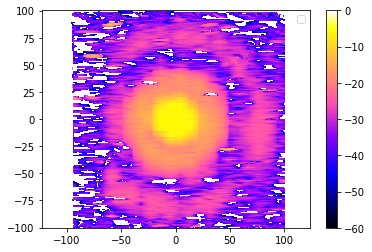

In [4]:
## Try some other gridding, maybe

d=0

# First, read in the pickle file

keys826 = [entry.split('dicts/')[1].split('.')[0] for entry in glob.glob('/hirax/GBO_Aug_2021/TONE_ACQ/flight_dicts/*')]
keys826.sort()

dict826 = {}

# flight 534
for key in ['20210826T185632Z']:
    with open('/hirax/GBO_Aug_2021/TONE_ACQ/flight_dicts/'+key+'.pkl', 'rb') as f:
        loaded_dict = pickle.load(f)
    dict826[key] = dict_to_class_cut(loaded_dict)
    print(key)
    
k_i = 3
k = keys826[k_i]
print(keys826[k_i])

# main beam fitting for this flight - look at params
fitdir = '/hirax/GBO_Analysis_Outputs/main_beam_fits/'
flyfile='FLY534_20210826T185621Z_ver_20230208T122919_2dGauss_and_Airy_Params.npz'
fits = np.load(fitdir+flyfile)

## Find indices with noise source on, not nan
inds_on_cut=np.intersect1d(np.arange(len(dict826[k].t_arr_datetime)),dict826[k].inds_on).tolist()
indsuse = [j for j in inds_on_cut if str(dict826[k].drone_xyz_LC_interp[j,0]) != 'nan']
    
# x, y : this will be the common for all data in this flight
x = dict826[k].drone_xyz_LC_interp[indsuse,0]
y = dict826[k].drone_xyz_LC_interp[indsuse,1]

z = dict826[k].V_bgsub[indsuse,freq_i,d]
theta = 0#fits['G_popt'][d,freq_i,5]
xc = fits['G_popt'][d,freq_i,1]
yc = fits['G_popt'][d,freq_i,3]
amp = fits['G_popt'][d,freq_i,0]
        
amp_corr = dict826[k].V_bgsub[indsuse,freq_i,d]/amp
plt.scatter(x,y,s=dotsize, c=amp_corr, cmap='gnuplot2')
plt.colorbar()
plt.show()  

xp,yp = get_newpointing(x,y,xc,yc,theta)       
plt.scatter(xp,yp,s=dotsize, c=amp_corr, cmap='gnuplot2')
plt.colorbar()
plt.show()
       
plt.scatter(xp,yp,s=dotsize, c=10*np.log10(amp_corr), cmap='gnuplot2')
plt.colorbar()
plt.show()

# linear gridding, for reference
LZ = griddata((xp,yp), amp_corr, (LX,LY), method='linear')

plt.pcolormesh(LX, LY, LZ, shading='auto',vmax=0.3, vmin=0.01)
plt.legend()
plt.colorbar()
plt.axis("equal")
plt.show()

plt.pcolormesh(LX,LY, 10*np.log10(LZ), shading='auto',cmap='gnuplot2',vmin=0,vmax=-60)
plt.legend()
plt.colorbar()
plt.axis("equal")
plt.show()

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 0.0009021120839710425
Full Sill: 0.0009042126736688273
Range: 33.58391866138239
Nugget: 2.100589697784692e-06 



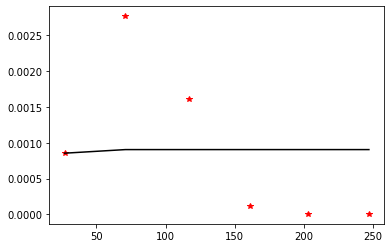

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



No handles with labels found to put in legend.


(100, 100) 100 100


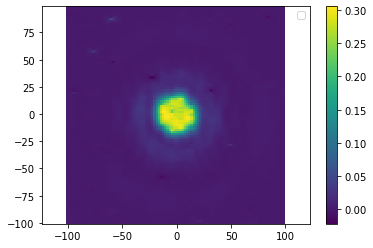

<ipython-input-5-90049c7868a3>:15: RuntimeWarning: invalid value encountered in log10
  plt.pcolormesh(X, Y, 10*np.log10(zstar), shading='auto', cmap='gnuplot2',vmin=0,vmax=-60)
No handles with labels found to put in legend.


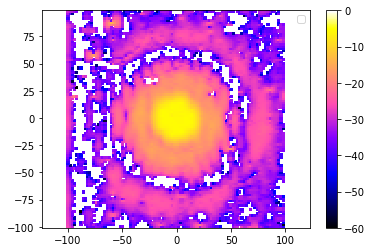

In [5]:
OK = OrdinaryKriging(xp,yp,amp_corr,variogram_model='spherical',verbose=True,enable_plotting=True)

X = np.arange(-100,100,2.0,dtype='float64')
Y = np.arange(-100,100,2.0,dtype='float64')
zstar,ss = OK.execute("grid",X,Y)
print(zstar.shape,len(X),len(Y))

plt.pcolormesh(X, Y, zstar, shading='auto')
plt.legend()
plt.colorbar()
plt.axis("equal")
plt.show()


plt.pcolormesh(X, Y, 10*np.log10(zstar), shading='auto', cmap='gnuplot2',vmin=0,vmax=-60)
plt.legend()
plt.colorbar()
plt.axis("equal")
plt.show()


In [ ]:
ni = get_slice(xp,yp,'x',-1,5.0)[0]
sx,sy,sz = [xp[ni],yp[ni],amp_corr[ni]]
print(np.median(xp[ni]))

gi = get_slice(X,Y,'x',-4.0,1.0)[0]
print(X[gi])

print(LX[1:2,239])

plt.figure(1,figsize=(12,12))
plt.plot(sy,10*np.log10(sz),'k.',label='data')
plt.plot(Y,10*np.log10(zstar[gi,:][0]),linewidth=2,label='Ordinary Kring grid')
plt.plot(LY[:,239],10*np.log10(LZ[:,239]),linewidth=2,label='Linear interp')
plt.legend()
plt.xlabel('Y [m]')
plt.title('Slice along x=5')
plt.ylabel('Amp [dB from Gaussian peak power]')
plt.show()

ni = get_slice(xp,yp,'y',0,1.5)[0]
sx,sy,sz = [xp[ni],yp[ni],amp_corr[ni]]
print(np.median(sz))

gi = get_slice(X,Y,'y',0,1.0)[0]
print(Y[gi])

print(LY[250,1:2])

plt.figure(1,figsize=(12,12))
plt.plot(sx,10*np.log10(sz),'k.',label='data')
plt.plot(X,10*np.log10(zstar[gi,:][0]),linewidth=2,label='Ordinary Kring grid')
plt.plot(LX[250,:],10*np.log10(LZ[250,:]),linewidth=2,label='Linear interp')
plt.legend()
plt.xlabel('X [m]')
plt.title('Slice along y=5')
plt.ylabel('Amp [dB from Gaussian peak power]')
plt.show()

In [ ]:
## Re-doing above with flight 535, an EW flight at same attenuation, etc. 

# First, read in the pickle file

keys826 = [entry.split('dicts/')[1].split('.')[0] for entry in glob.glob('/hirax/GBO_Aug_2021/TONE_ACQ/flight_dicts/*')]
keys826.sort()

dict826 = {}

# flight 535
for key in ['20210826T192108Z']:
    with open('/hirax/GBO_Aug_2021/TONE_ACQ/flight_dicts/'+key+'.pkl', 'rb') as f:
        loaded_dict = pickle.load(f)
    dict826[key] = dict_to_class_cut(loaded_dict)
    print(key)
    
k_i = 4
k = keys826[k_i]
print(keys826[k_i])

# main beam fitting for this flight - look at params
fitdir = '/hirax/GBO_Analysis_Outputs/main_beam_fits/'
flyfile='FLY535_20210826T192056Z_ver_20230208T124740_2dGauss_and_Airy_Params.npz'
fits = np.load(fitdir+flyfile)

## Find indices with noise source on, not nan
inds_on_cut=np.intersect1d(np.arange(len(dict826[k].t_arr_datetime)),dict826[k].inds_on).tolist()
indsuse = [j for j in inds_on_cut if str(dict826[k].drone_xyz_LC_interp[j,0]) != 'nan']
    
# x, y : this will be the common for all data in this flight
x = dict826[k].drone_xyz_LC_interp[indsuse,0]
y = dict826[k].drone_xyz_LC_interp[indsuse,1]

z = dict826[k].V_bgsub[indsuse,freq_i,d]
theta = 0#fits['G_popt'][d,freq_i,5]
xc = fits['G_popt'][d,freq_i,1]
yc = fits['G_popt'][d,freq_i,3]
amp = fits['G_popt'][d,freq_i,0]
        
amp_corr = dict826[k].V_bgsub[indsuse,freq_i,d]/amp
plt.scatter(x,y,s=dotsize, c=amp_corr, cmap='gnuplot2')
plt.colorbar()
plt.show()  

xp,yp = get_newpointing(x,y,xc,yc,theta)       
plt.scatter(xp,yp,s=dotsize, c=amp_corr, cmap='gnuplot2')
plt.colorbar()
plt.show()
      
plt.scatter(xp,yp,s=dotsize, c=10*np.log10(amp_corr), cmap='gnuplot2')
plt.colorbar()
plt.show()

# linear gridding, for reference
LZ_2 = griddata((xp,yp), amp_corr, (LX,LY), method='linear')

plt.pcolormesh(LX, LY, LZ_2, shading='auto',cmap='gnuplot2',vmax=0.3, vmin=0.01)
plt.legend()
plt.colorbar()
plt.axis("equal")
plt.show()

plt.pcolormesh(LX,LY, 10*np.log10(LZ_2), shading='auto',cmap='gnuplot2',vmin=0,vmax=-60)
plt.legend()
plt.colorbar()
plt.axis("equal")
plt.show()


0.1

In [ ]:
# cheeky: just add them together
plt.pcolormesh(LX, LY, (LZ + LZ_2)/2, shading='auto',cmap='gnuplot2',vmin=0,vmax=0.3)
plt.legend()
plt.colorbar()
plt.axis("equal")
plt.title('Flight 534 - Flight 535')
plt.show()

plt.pcolormesh(LX, LY, 10*np.log10((LZ + LZ_2)/2), shading='auto',cmap='gnuplot2',vmin=-40,vmax=0)
plt.legend()
plt.colorbar()
plt.axis("equal")
plt.title('Flight 534 - Flight 535')
plt.show()

## difference two griddings - Krige
plt.pcolormesh(X, Y, (zstar+zstar_2)/2, shading='auto',cmap='gnuplot2',vmin=0,vmax=0.3)
plt.legend()
plt.colorbar()
plt.axis("equal")
plt.show()


plt.pcolormesh(X, Y, 10*np.log10((zstar + zstar_2)/2), shading='auto', cmap='gnuplot2',vmin=-40,vmax=0)
plt.legend()
plt.colorbar()
plt.axis("equal")
plt.show()


<ipython-input-9-bbf5acfc46c5>:8: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(xpp,ypp,s=dotsize, c=10*np.log10(zpp), cmap='gnuplot2')
<ipython-input-9-bbf5acfc46c5>:8: RuntimeWarning: invalid value encountered in log10
  plt.scatter(xpp,ypp,s=dotsize, c=10*np.log10(zpp), cmap='gnuplot2')


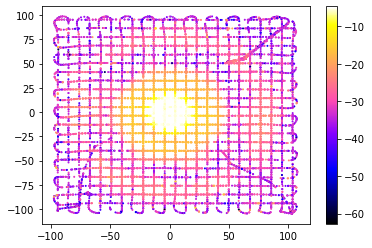

In [9]:
# cheeky but less cheeky: combine the two flights

# first, combine two data sets together
xpp = np.concatenate((xp, xp_2))
ypp = np.concatenate((yp,yp_2))
zpp = np.concatenate((amp_corr, amp_corr_2))

plt.scatter(xpp,ypp,s=dotsize, c=10*np.log10(zpp), cmap='gnuplot2')
plt.colorbar()
plt.show()



No handles with labels found to put in legend.


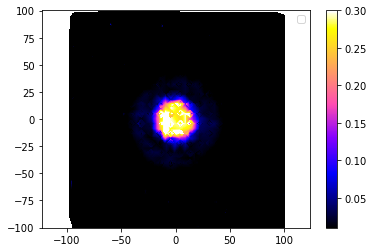

<ipython-input-10-7f46f2f42062>:10: RuntimeWarning: invalid value encountered in log10
  plt.pcolormesh(LX,LY, 10*np.log10(LZpp), shading='auto',cmap='gnuplot2',vmin=0,vmax=-60)
No handles with labels found to put in legend.


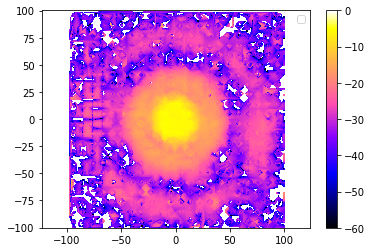

In [10]:
# linear gridding, for reference
LZpp = griddata((xpp,ypp), zpp, (LX,LY), method='linear')

plt.pcolormesh(LX, LY, LZpp, shading='auto',cmap='gnuplot2',vmax=0.3, vmin=0.01)
plt.legend()
plt.colorbar()
plt.axis("equal")
plt.show()

plt.pcolormesh(LX,LY, 10*np.log10(LZpp), shading='auto',cmap='gnuplot2',vmin=0,vmax=-60)
plt.legend()
plt.colorbar()
plt.axis("equal")
plt.show()


Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 0.000982268086158208
Full Sill: 0.0009849495190906573
Range: 35.96390858223097
Nugget: 2.681432932449246e-06 



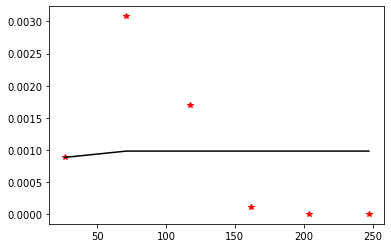

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



No handles with labels found to put in legend.


(100, 100) 100 100


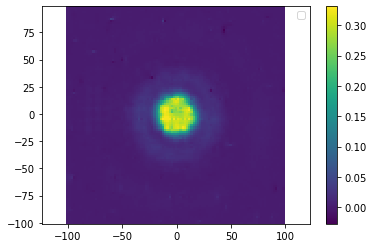

<ipython-input-11-a657f083fb30>:15: RuntimeWarning: invalid value encountered in log10
  plt.pcolormesh(X, Y, 10*np.log10(zstar), shading='auto', cmap='gnuplot2',vmin=0,vmax=-60)
No handles with labels found to put in legend.


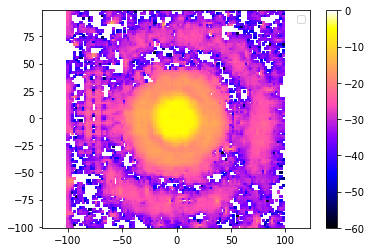

In [11]:
OK = OrdinaryKriging(xpp,ypp,zpp,variogram_model='spherical',verbose=True,enable_plotting=True)

X = np.arange(-100,100,2.0,dtype='float64')
Y = np.arange(-100,100,2.0,dtype='float64')
zstar,ss = OK.execute("grid",X,Y)
print(zstar.shape,len(X),len(Y))

plt.pcolormesh(X, Y, zstar, shading='auto')
plt.legend()
plt.colorbar()
plt.axis("equal")
plt.show()


plt.pcolormesh(X, Y, 10*np.log10(zstar), shading='auto', cmap='gnuplot2',vmin=0,vmax=-60)
plt.legend()
plt.colorbar()
plt.axis("equal")
plt.show()

<ipython-input-13-960f4054e6d8>:1: RuntimeWarning: invalid value encountered in log10
  plt.pcolormesh(LX,LY, 10*np.log10(LZpp), shading='auto',cmap='gnuplot2',vmin=0,vmax=-60)
No handles with labels found to put in legend.


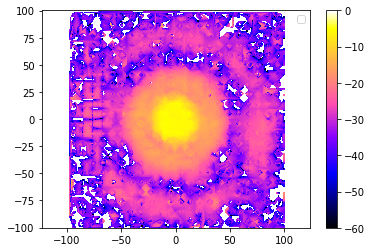

<ipython-input-13-960f4054e6d8>:7: RuntimeWarning: invalid value encountered in log10
  plt.pcolormesh(X, Y, 10*np.log10(zstar), shading='auto', cmap='gnuplot2',vmin=0,vmax=-60)
No handles with labels found to put in legend.


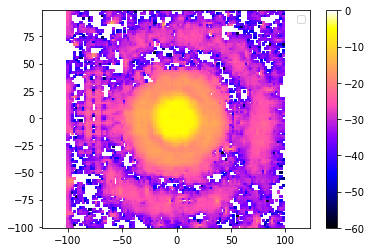

In [13]:
plt.pcolormesh(LX,LY, 10*np.log10(LZpp), shading='auto',cmap='gnuplot2',vmin=0,vmax=-60)
plt.legend()
plt.colorbar()
plt.axis("equal")
plt.show()

plt.pcolormesh(X, Y, 10*np.log10(zstar), shading='auto', cmap='gnuplot2',vmin=0,vmax=-60)
plt.legend()
plt.colorbar()
plt.axis("equal")
plt.show()

-4.139635107983324
[-4.]
[-4.20841683]


<ipython-input-23-8f9d69d7006f>:11: RuntimeWarning: invalid value encountered in log10
  plt.plot(sy,10*np.log10(sz),'k.',label='data')
<ipython-input-23-8f9d69d7006f>:12: RuntimeWarning: invalid value encountered in log10
  plt.plot(Y,10*np.log10(zstar[gi,:][0]),linewidth=2,label='Ordinary Kring grid')
<ipython-input-23-8f9d69d7006f>:13: RuntimeWarning: invalid value encountered in log10
  plt.plot(LY[:,239],10*np.log10(LZ[:,239]),linewidth=2,label='Linear interp')


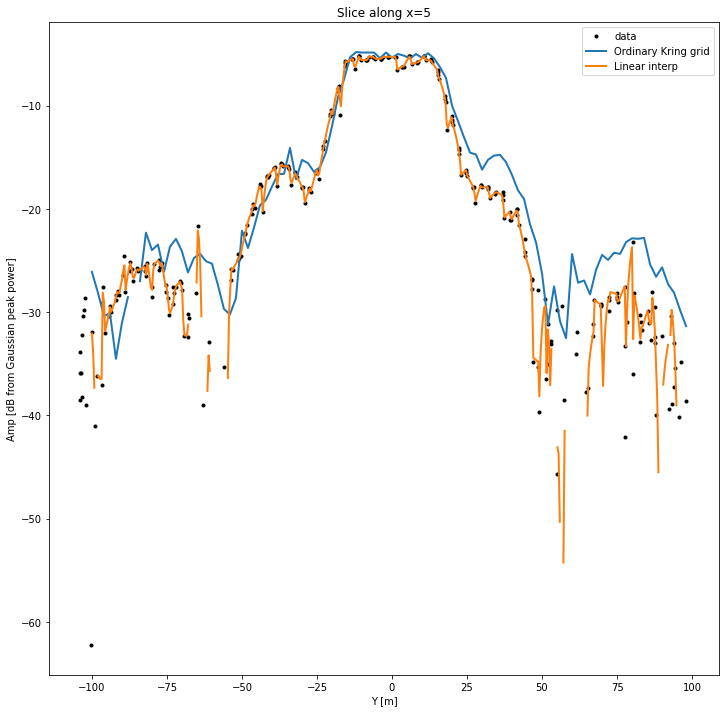

<ipython-input-23-8f9d69d7006f>:30: RuntimeWarning: invalid value encountered in log10
  plt.plot(sx,10*np.log10(sz),'k.',label='data')


-3.4412765048544562
[-4. -2.]
[0.2004008]


<ipython-input-23-8f9d69d7006f>:31: RuntimeWarning: invalid value encountered in log10
  plt.plot(X,10*np.log10(zstar[gi,:][0]),linewidth=2,label='Ordinary Kring grid')
<ipython-input-23-8f9d69d7006f>:32: RuntimeWarning: invalid value encountered in log10
  plt.plot(LX[250,:],10*np.log10(LZ[250,:]),linewidth=2,label='Linear interp')


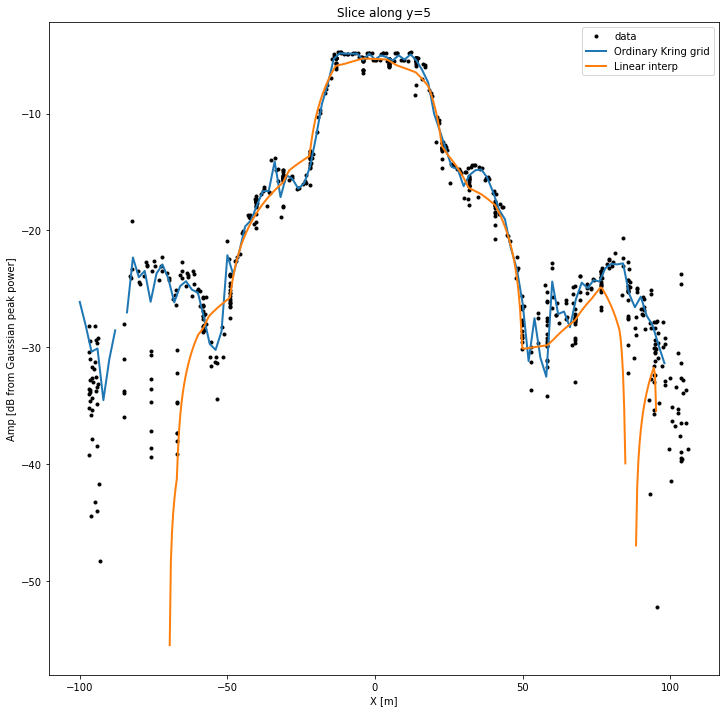

In [23]:
ni = get_slice(xp,yp,'x',-4,2.0)[0]
sx,sy,sz = [xpp[ni],ypp[ni],zpp[ni]]
print(np.median(xpp[ni]))

gi = get_slice(X,Y,'x',-4.0,1.0)[0]
print(X[gi])

print(LX[1:2,239])

plt.figure(1,figsize=(12,12))
plt.plot(sy,10*np.log10(sz),'k.',label='data')
plt.plot(Y,10*np.log10(zstar[gi,:][0]),linewidth=2,label='Ordinary Kring grid')
plt.plot(LY[:,239],10*np.log10(LZ[:,239]),linewidth=2,label='Linear interp')
plt.legend()
plt.xlabel('Y [m]')
plt.title('Slice along x=5')
plt.ylabel('Amp [dB from Gaussian peak power]')
plt.show()

ni = get_slice(xpp,ypp,'y',0,5.0)[0]
sx,sy,sz = [xpp[ni],ypp[ni],zpp[ni]]
print(np.median(ypp[ni]))

gi = get_slice(X,Y,'y',-3,1.0)[0]
print(Y[gi])

print(LY[250,1:2])

plt.figure(1,figsize=(12,12))
plt.plot(sx,10*np.log10(sz),'k.',label='data')
plt.plot(X,10*np.log10(zstar[gi,:][0]),linewidth=2,label='Ordinary Kring grid')
plt.plot(LX[250,:],10*np.log10(LZ[250,:]),linewidth=2,label='Linear interp')
plt.legend()
plt.xlabel('X [m]')
plt.title('Slice along y=5')
plt.ylabel('Amp [dB from Gaussian peak power]')
plt.show()

# 2. Subtracting one flight from the other

In [ ]:
### This block tries to use the two for loops below to regrid two flights #####
## and subtract them #####

dishes = [0,2,4]
X,Y = np.meshgrid(np.linspace(-50,50,res), np.linspace(-50,50,res))

# First, read in the pickle file

keys826 = [entry.split('dicts/')[1].split('.')[0] for entry in glob.glob('/hirax/GBO_Aug_2021/TONE_ACQ/flight_dicts/*')]
keys826.sort()
print(keys826)

dict826 = {}

# set up for the two flights I'm interested in: 534, 535
k_i = [3,4]
flyfiles = ['FLY534_20210826T185621Z_ver_20230208T122919_2dGauss_and_Airy_Params.npz',
           'FLY535_20210826T192056Z_ver_20230208T124740_2dGauss_and_Airy_Params.npz']

for k in k_i:
    key = keys826[k]
    with open('/hirax/GBO_Aug_2021/TONE_ACQ/flight_dicts/'+key+'.pkl', 'rb') as f:
        loaded_dict = pickle.load(f)
    dict826[key] = dict_to_class_cut(loaded_dict)
    print(k, key)


In [ ]:
print(dict826['20210826T185632Z'])

In [ ]:
Nf = 1024
Nd = len(dishes)
amprat = np.zeros([Nf,Nd,2])
Z = np.zeros([len(X[:,0]),len(X[0,:]),Nf, Nd, 2])
        
for flight in [0,1]:
        print(datetime.datetime.now())
        print('Now on flight: ', flight)
        i = k_i[flight]
        key = keys826[i]
        inds_on_cut=np.intersect1d(np.arange(len(dict826[key].t_arr_datetime)),dict826[key].inds_on).tolist()
        indsuse = [j for j in inds_on_cut if str(dict826[key].drone_xyz_LC_interp[j,0]) != 'nan']
        Nt = len(indsuse)
        x = dict826[key].drone_xyz_LC_interp[indsuse,0]
        y = dict826[key].drone_xyz_LC_interp[indsuse,1]

        # main beam fitting for this flight - look at params

        flyfile=flyfiles[flight]
        fits = np.load(fitdir+flyfile)
        print(flight,i, key,flyfile)

        # correct for the centroids, amplitudes. These will be per dish, frequency
        xp = np.zeros([len(x),Nf,Nd])
        yp = np.zeros([len(y),Nf,Nd])
        amp_corr = np.zeros([Nt,Nf,Nd])

        for d in np.arange(Nd):
            print('Now on dish: ', d)
            for f in np.arange(Nf):
                try:
                    z = dict826[key].V_bgsub[indsuse,f,dishes[d]]
                    theta = 0.0#fits['G_popt'][dishes[d],f,5]
                    xc = fits['G_popt'][dishes[d],f,1]
                    yc = fits['G_popt'][dishes[d],f,3]
                    amp = fits['G_popt'][dishes[d],f,0]
        
                    #print(dishes[d], f, max(z),amp, max(z)/amp)
                    amp_corr[:,f,d] = dict826[key].V_bgsub[indsuse,f,dishes[d]]/amp
                    xp[:,f,d], yp[:,f,d] = get_newpointing(x,y,xc,yc,theta)       

                    # try gridddata
                    Z[:,:,f,d,flight] = griddata((xp[:,f,d],yp[:,f,d]), amp_corr[:,f,d], (X,Y), method='linear')
                    amprat[f,d,flight] = Z[int(res/2),int(res/2),f,d,flight]

                except:''
        print(datetime.datetime.now())



In [ ]:
d = 0
f=freq_i+1
flight=0

plt.pcolormesh(X, Y, Z[:,:,f,d,flight], shading='auto',vmax=1.0, vmin=0.01)
plt.legend()
plt.colorbar()
plt.axis("equal")
plt.show()

print(amprat[f,d,flight])

flight=1

plt.pcolormesh(X, Y, Z[:,:,f,d,flight], shading='auto',vmax=1.0, vmin=0.01)
plt.legend()
plt.colorbar()
plt.axis("equal")
plt.show()

print(amprat[f,d,flight])

In [ ]:
R2 = int(res/2)
pm = 3
statsarr = np.zeros([Nf, Nd, 3])

for f in [freq_i]:
    for d in np.arange(Nd):
        statsarr[f,d,0] = np.nanstd(np.matrix.flatten(Z[:,:,f,d,1] - Z[:,:,f,d,0])) # std across regrid
        statsarr[f,d,1] = np.nanmedian(np.matrix.flatten(Z[R2-pm:R2+pm,R2-pm:R2+pm,f,d,1] - Z[R2-pm:R2+pm,R2-pm:R2+pm,f,d,0]))
        statsarr[f,d,2] = np.nanstd(np.matrix.flatten(
            Z[R2-pm:R2+pm,R2-pm:R2+pm,f,d,1] - Z[R2-pm:R2+pm,R2-pm:R2+pm,f,d,0])) # std across regrid
        #print('STD across this pixel set:',statsarr[f,d,0])
        #print('Median value around central pixel: ', statsarr[f,d,1])

In [ ]:
for d in np.arange(Nd):
    plt.plot(freqs,statsarr[:,d,0]*100.)
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('STD [%]')
plt.show()

for d in np.arange(Nd):
    plt.plot(freqs,statsarr[:,d,1]*100,marker='.',linestyle='None')
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('median value around central pixel [%]')
plt.ylim(-25,25)
plt.show()

for d in np.arange(Nd):
    plt.plot(freqs,statsarr[:,d,2]*100,marker='.',linestyle='None')
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('STD around central pixel [%]')
#plt.ylim(-25,25)
plt.show()

In [ ]:
for f in [freq_i]:
    for d in np.arange(Nd):
        plt.pcolormesh(X, Y, Z[:,:,f,d,1] - Z[:,:,f,d,0], shading='auto',vmin=-0.1,vmax=0.1)
        plt.xlim(-50,50)
        plt.ylim(-50,50)
        plt.legend()
        plt.colorbar()
        plt.axis("equal")
        plt.title('Flight 535 - Flight 534 - include theta')
        plt.show()


In [ ]:
## Linear gridding
# 0.0825s per grid = ~4.5mins total for 3 dishes, 1024 freqs

### First, let's look at one single flight and do some basic manipulations ####
## start with flight 534 (E pol, NS grid)
dishes = [0,2,4]
X,Y = np.meshgrid(np.linspace(-50,50,res), np.linspace(-50,50,res))

# First, read in the pickle file

keys826 = [entry.split('dicts/')[1].split('.')[0] for entry in glob.glob('/hirax/GBO_Aug_2021/TONE_ACQ/flight_dicts/*')]
keys826.sort()

dict826 = {}

# flight 534
for key in ['20210826T185632Z']:
    with open('/hirax/GBO_Aug_2021/TONE_ACQ/flight_dicts/'+key+'.pkl', 'rb') as f:
        loaded_dict = pickle.load(f)
    dict826[key] = dict_to_class_cut(loaded_dict)
    print(key)
    
k_i = 3
k = keys826[k_i]
print(keys826[k_i])
print(dict826[k].t_arr_datetime)

# main beam fitting for this flight - look at params
fitdir = '/hirax/GBO_Analysis_Outputs/main_beam_fits/'
flyfile='FLY534_20210826T185621Z_ver_20230208T122919_2dGauss_and_Airy_Params.npz'
fits = np.load(fitdir+flyfile)

## Find indices with noise source on, not nan
inds_on_cut=np.intersect1d(np.arange(len(dict826[k].t_arr_datetime)),dict826[k].inds_on).tolist()
indsuse = [j for j in inds_on_cut if str(dict826[k].drone_xyz_LC_interp[j,0]) != 'nan']
    
# x, y : this will be the common for all data in this flight
x = dict826[k].drone_xyz_LC_interp[indsuse,0]
y = dict826[k].drone_xyz_LC_interp[indsuse,1]

# correct for the centroids, amplitudes. These will be per dish, frequency
Nf = len(dict826[k].V_bgsub[0,:,0])
Nd = len(dishes)
Nt = len(indsuse)

xp = np.zeros([len(x),Nf,Nd])
yp = np.zeros([len(y),Nf,Nd])
amp_corr = np.zeros([Nt,Nf,Nd])
amprat = np.zeros([Nf,Nd])

print(datetime.datetime.now())
print('WORKING...')
for d in np.arange(Nd):
    print('Now on dish: ', d)
    for f in np.arange(Nf-1):
        try:
            z = dict826[k].V_bgsub[indsuse,f,dishes[d]]
            theta = fits['G_popt'][dishes[d],f,5]
            xc = fits['G_popt'][dishes[d],f,1]
            yc = fits['G_popt'][dishes[d],f,3]
            amp = fits['G_popt'][dishes[d],f,0]
        
            #print(dishes[d], f, max(z),amp, max(z)/amp)
            amp_corr[:,f,d] = dict826[k].V_bgsub[indsuse,f,dishes[d]]/amp
            #plt.scatter(x,y,s=dotsize, c=amp_corr[:,freq_i,d], cmap='gnuplot2')
            #plt.colorbar()
            #plt.show()  

            xp[:,f,d], yp[:,f,d] = get_newpointing(x,y,xc,yc,theta)       

            # try gridddata
            Z2 = griddata((xp[:,f,d],yp[:,f,d]), amp_corr[:,f,d], (X,Y), method='linear')
            amprat[f,d] = Z2[int(res/2),int(res/2)]
            #plt.pcolormesh(X, Y, Z2, shading='auto',vmax=0.8, vmin=0.01)
            #plt.legend()
            #plt.colorbar()
            #plt.axis("equal")
            #plt.show()
        except:''
print(datetime.datetime.now())

In [ ]:
plt.figure(1,figsize=(10,10))
plt.subplot(211)
plt.plot(amprat[:,0],label='Dish 0')
plt.plot(amprat[:,1],label='Dish 1')
plt.plot(amprat[:,2],label='Dish 2')
plt.ylabel('Central pix / Gauss amp')
plt.legend()
plt.subplot(212)
plt.plot(fits['G_popt'][dishes[0],:,0],label='Dish 0')
plt.plot(fits['G_popt'][dishes[1],:,0],label='Dish 1')
plt.plot(fits['G_popt'][dishes[2],:,0],label='Dish 2')
plt.ylabel('Fit amplitude')
plt.legend()
plt.suptitle('Flight 534')
plt.show()

In [ ]:
# flight 535

keys826 = [entry.split('dicts/')[1].split('.')[0] for entry in glob.glob('/hirax/GBO_Aug_2021/TONE_ACQ/flight_dicts/*')]
keys826.sort()

dict826 = {}

for key in ['20210826T192108Z']:
    with open('/hirax/GBO_Aug_2021/TONE_ACQ/flight_dicts/'+key+'.pkl', 'rb') as f:
        loaded_dict = pickle.load(f)
    dict826[key] = dict_to_class_cut(loaded_dict)
    print(key)
    
k_i = 4
k = keys826[k_i]
print(keys826[k_i])
print(dict826[k].t_arr_datetime)

fitdir = '/hirax/GBO_Analysis_Outputs/main_beam_fits/'
flyfile='FLY535_20210826T192056Z_ver_20230208T124740_2dGauss_and_Airy_Params.npz'
fits = np.load(fitdir+flyfile)

## Find indices with noise source on, not nan
inds_on_cut=np.intersect1d(np.arange(len(dict826[k].t_arr_datetime)),dict826[k].inds_on).tolist()
indsuse = [j for j in inds_on_cut if str(dict826[k].drone_xyz_LC_interp[j,0]) != 'nan']
    
# x, y : this will be the common for all data in this flight
x = dict826[k].drone_xyz_LC_interp[indsuse,0]
y = dict826[k].drone_xyz_LC_interp[indsuse,1]

# correct for the centroids, amplitudes. These will be per dish, frequency
Nf = len(dict826[k].V_bgsub[0,:,0])
Nd = len(dishes)
Nt = len(indsuse)

xp = np.zeros([len(x),Nf,Nd])
yp = np.zeros([len(y),Nf,Nd])
amp_corr = np.zeros([Nt,Nf,Nd])
amprat = np.zeros([Nf,Nd])

print(datetime.datetime.now())
print('WORKING...')
for d in np.arange(Nd):
    print('Now on dish: ', d)
    for f in np.arange(Nf-1):
        try:
            z = dict826[k].V_bgsub[indsuse,f,dishes[d]]
            theta = fits['G_popt'][dishes[d],f,5]
            xc = fits['G_popt'][dishes[d],f,1]
            yc = fits['G_popt'][dishes[d],f,3]
            amp = fits['G_popt'][dishes[d],f,0]
        
            #print(dishes[d], f, max(z),amp, max(z)/amp)
            amp_corr[:,f,d] = dict826[k].V_bgsub[indsuse,f,dishes[d]]/amp
            #plt.scatter(x,y,s=dotsize, c=amp_corr[:,freq_i,d], cmap='gnuplot2')
            #plt.colorbar()
            #plt.show()  

            xp[:,f,d], yp[:,f,d] = get_newpointing(x,y,xc,yc,theta)      

            # try gridddata
            Z2 = griddata((xp[:,f,d],yp[:,f,d]), amp_corr[:,f,d], (X,Y), method='linear')
            amprat[f,d] = Z2[int(res/2),int(res/2)]
            #plt.pcolormesh(X, Y, Z2, shading='auto',vmax=0.8, vmin=0.01)
            #plt.legend()
            #plt.colorbar()
            #plt.axis("equal")
            #plt.show()
        except:''
print(datetime.datetime.now())

In [ ]:
plt.figure(1,figsize=(10,10))
plt.subplot(211)
plt.plot(amprat[:,0],label='Dish 0')
plt.plot(amprat[:,1],label='Dish 1')
plt.plot(amprat[:,2],label='Dish 2')
plt.ylabel('Central pix / Gauss amp')
plt.legend()
plt.subplot(212)
plt.plot(fits['G_popt'][dishes[0],:,0],label='Dish 0')
plt.plot(fits['G_popt'][dishes[1],:,0],label='Dish 1')
plt.plot(fits['G_popt'][dishes[2],:,0],label='Dish 2')
plt.ylabel('Fit amplitude')
plt.legend()
plt.suptitle('Flight 535')
plt.show()

In [ ]:
plt.pcolormesh(X_2, Y_2, Z2 - Z2_2, shading='auto',vmin=-0.4,vmax=0.4)
plt.legend()
plt.colorbar()
plt.axis("equal")
plt.title('Flight 534 - Flight 535')
plt.show()

plt.pcolormesh(X_2, Y_2, Z2 - Z2_2, shading='auto',vmin=-0.1,vmax=0.1)
plt.xlim(-50,50)
plt.ylim(-50,50)
plt.legend()
plt.colorbar()
plt.axis("equal")
plt.title('Flight 534 - Flight 535 - include theta')
plt.show()

print('STD across this pixel set:',np.nanstd(np.matrix.flatten(Z2 - Z2_2)))

# 1. Reading in Gaussian fit params from fit files and comparing

In [ ]:
fitdir='/hirax/GBO_Analysis_Outputs/main_beam_fits/'

ffiles = ['FLY533_20210826T182904Z_ver_20230208T115529_2dGauss_and_Airy_Params.npz',
         'FLY536_20210826T195003Z_ver_20230209T122731_2dGauss_and_Airy_Params.npz',
         'FLY613_20211021T144905Z_ver_20230212T220917_2dGauss_and_Airy_Params.npz',
         'FLY615_20211021T151650Z_2dGauss_and_Airy_Params.npz','FLY618_20211021T183430Z_2dGauss_and_Airy_Params.npz']

########################################################################
########### Check basics ####  #####  #####  ######  ### ############### 
########################################################################


## Investigating North pol flights only, let's plot only the co-pol fit values
cm = plt.get_cmap('Spectral')

fits = np.load(fitdir+ffiles[0])
N = len(fits['G_popt'][:,400,0])

fig = plt.figure(figsize=(1,1))
ax = fig.add_subplot(111)
fig, axs = plt.subplots(6,1,figsize=(15,15))
ax.set_prop_cycle(color=[cm(1.*i/N) for i in range(N)])

markers=[',','.','x','^','>']
msize=[3,2,1,1,1]
for f in range(0,len(ffiles)):
    fits = np.load(fitdir+ffiles[f])
    for d in Npols:
  
        axs[0].plot(freqs,fits['G_popt'][d,:,1],marker=markers[f],ms=msize[f],linestyle='None')
        axs[0].set_ylim(-20,20)
        axs[0].set_ylabel('X centroid')
        
        axs[1].plot(freqs,fits['G_popt'][d,:,3],marker=markers[f],ms=msize[f],linestyle='None')
        axs[1].set_ylim(-20,20)
        axs[1].set_ylabel('Y centroid')

        axs[2].plot(freqs,fits['G_popt'][d,:,2],marker=markers[f],ms=msize[f],linestyle='None')
        axs[2].set_ylim(0,20)
        axs[2].set_ylabel('Xsig')
        
        axs[3].plot(freqs,fits['G_popt'][d,:,4],marker=markers[f],ms=msize[f],linestyle='None')
        axs[3].set_ylim(0,20)
        axs[3].set_ylabel('Ysig')

        axs[4].plot(freqs,fits['G_popt'][d,:,0],marker=markers[f],ms=msize[f],linestyle='None')
        axs[4].set_ylim(0,4E-7)
        axs[4].set_ylabel('Amp')

        axs[5].plot(freqs,np.degrees(fits['G_popt'][d,:,5]),marker=markers[f],ms=msize[f],linestyle='None')
        axs[5].set_ylim(-45,45)
        axs[5].set_ylabel('Theta [deg]')
fig.show()



In [ ]:
########################################################################
########### Check mapping between input and polarization ############### 
########################################################################



cm = plt.get_cmap('Spectral')

fits = np.load(fitdir+ffiles[-1])
N = len(fits['G_popt'][:,400,0])
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1.*i/N) for i in range(N)])
f = 700
for i in range(0,N):
    if (i in Epols):
        ax.plot(freqs,fits['G_popt'][i,:,0],marker='.',ms=1,linestyle='None',label=str(i))
        #print('in Epols',i,fits['G_popt'][i,f,0])
    if (i in Npols):
        ax.plot(freqs,fits['G_popt'][i,:,0],marker='s',ms=3,linestyle='None',label=str(i))
        #print('in Npols',i,fits['G_popt'][i,f,0])
    ax.set_ylim(0,4E-7)
    #ax.set_xlim(400,575)
    #ylabel('Gaussian fit amplitude')
    #xlabel('Frequency [MHz]')
    #title('Flight 535')
ax.legend(markerscale=3)
fig.show()









In [ ]:
########################################################################
### Compare Gaussian fits between two flights, grouped by polarization #
########################################################################



markers=[',','.','x','+','^']
for f in range(0,len(ffiles)):
    cmap='Spectral'
    fig = plt.figure(figsize=(1,1))
    ax = fig.add_subplot(111)
    fig, axs = plt.subplots(6,1,figsize=(15, 15))
    ax.set_prop_cycle(color=[cm(1.*i/N) for i in range(N)])
    fits1 = np.load(fitdir+ffiles[f])
    if f+1 == len(ffiles):
        print('Using f=0', f, ffiles[0])
        fits2 = np.load(fitdir+ffiles[0])
    if f+1 < len(ffiles):
        print('Using next file up', f, ffiles[f+1])
        fits2 = np.load(fitdir+ffiles[f+1])
        
    for d in Npols:
        axs[0].plot(freqs,fits1['G_popt'][d,:,1]-fits2['G_popt'][d,:,1],marker=markers[f],linestyle='None')
        axs[0].set_ylim(-4,4)
        axs[0].set_ylabel('$\Delta$ X centroid [m]')
        axs[0].set_title(ffiles[f])
        
        axs[1].plot(freqs,fits1['G_popt'][d,:,3]-fits2['G_popt'][d,:,3],marker=markers[f],linestyle='None')
        axs[1].set_ylim(-4,4)
        axs[1].set_ylabel('$\Delta$ Y centroid [m]')

        axs[2].plot(freqs,fits1['G_popt'][d,:,2]-fits2['G_popt'][d,:,2],marker=markers[f],linestyle='None')
        axs[2].set_ylim(-4,4)
        axs[2].set_ylabel('$\Delta$ Xsig [m]')
        
        axs[3].plot(freqs,fits1['G_popt'][d,:,4]-fits2['G_popt'][d,:,4],marker=markers[f],linestyle='None')
        axs[3].set_ylim(-4,4)
        axs[3].set_ylabel('$\Delta$ Ysig [m]')

        axs[4].plot(freqs,fits1['G_popt'][d,:,0]-fits2['G_popt'][d,:,0],marker=markers[f],linestyle='None')
        axs[4].set_ylim(-4E-7,4E-7)
        axs[4].set_ylabel('$\Delta$ Amp')

        axs[5].plot(freqs,np.degrees(fits1['G_popt'][d,:,5])-np.degrees(fits2['G_popt'][d,:,5]),marker=markers[f],linestyle='None')
        axs[5].set_ylim(-90,90)
        axs[5].set_ylabel('$\Delta$ Theta [deg]')
    fig.show()


In [ ]:
##### Emily's original code #####


def Gauss_2d_LC_func(P,x,y):
    amp,x0,xsig,y0,ysig,c=P
    return amp*np.exp(-0.5*((((x-x0)/xsig)**2.0)+(((y-y0)/ysig)**2.0)))+c

def Gauss_2d_LC_func_gen(P,x,y):
    amp,x0,xsig,y0,ysig,theta,c=P
    A=(0.5*(((np.cos(theta)/xsig)**2.0)+((np.sin(theta)/ysig)**2.0)))
    B=(0.25*((np.sin(2.0*theta)/(ysig**2.0))-(np.sin(2.0*theta)/(xsig**2.0))))
    C=(0.5*(((np.sin(theta)/xsig)**2.0)+((np.cos(theta)/ysig)**2.0)))
    return amp*np.exp(-1.0*((A*((x-x0)**2.0))+(2.0*B*(x-x0)*(y-y0))+(C*((y-y0)**2.0))))+c

def Gauss_2d_LC_opt_gen(P,x,y,V):
    amp,x0,xsig,y0,ysig,theta,c=P
    A=(0.5*(((np.cos(theta)/xsig)**2.0)+((np.sin(theta)/ysig)**2.0)))
    B=(0.25*((np.sin(2.0*theta)/(ysig**2.0))-(np.sin(2.0*theta)/(xsig**2.0))))
    C=(0.5*(((np.sin(theta)/xsig)**2.0)+((np.cos(theta)/ysig)**2.0)))
    return amp*np.exp(-1.0*((A*((x-x0)**2.0))+(2.0*B*(x-x0)*(y-y0))+(C*((y-y0)**2.0))))+c-V

## AUGUST 26 FLIGHT READ IN

keys826 = [entry.split('dicts/')[1].split('.')[0] for entry in glob.glob('/hirax/GBO_Aug_2021/TONE_ACQ/flight_dicts/*')]
keys826.sort()

dict826 = {}

#just look at 2 flights with the same drone transmitter orientation

#for key in ['20210826T182915Z','20210826T195014Z']: 
for key in ['20210826T170324Z','20210826T162036Z']:#,'20210826T192108Z']:
    with open('/hirax/GBO_Aug_2021/TONE_ACQ/flight_dicts/'+key+'.pkl', 'rb') as f:
        loaded_dict = pickle.load(f)
    dict826[key] = dict_to_class_cut(loaded_dict)
    print(key)
    
fig=figure(figsize=(14,5))
counter = 1
vmin_ = -105

for k, i in enumerate(keys826):
    try: 
        dotsize=1
        freq = 900
        inds_on_cut=np.intersect1d(np.arange(len(dict826[i].t_arr_datetime)),dict826[i].inds_on).tolist()
        indsuse = [j for j in inds_on_cut if str(dict826[i].drone_xyz_LC_interp[j,0]) != 'nan']
        x = dict826[i].drone_xyz_LC_interp[indsuse,0]
        y = dict826[i].drone_xyz_LC_interp[indsuse,1]

        ax=fig.add_subplot(2,6,counter)
        z = 10*np.log10(np.abs(np.mean(dict826[i].V_bgsub[indsuse,freq:freq+20,0], axis = 1)))
        ax.scatter(x,y, s=dotsize, c=z, cmap='gnuplot2', vmin = -100)
        ax.set_title('flight '+str(k) + ' pol 0')

        ax=fig.add_subplot(2,6,counter+6)
        z = 10*np.log10(np.abs(np.mean(dict826[i].V_bgsub[indsuse,freq:freq+20,1], axis = 1)))
        ax.scatter(x,y, s=dotsize, c=z, cmap='gnuplot2', vmin = -100)
        ax.set_title('flight '+str(k) + ' pol 1')
        counter +=1

    except: pass
# suptitle('August Flight Catalog', y=1.02, fontsize = 15)
tight_layout()

res = 500

X,Y = np.meshgrid(np.linspace(-100,100,500), np.linspace(-100,100,500))


num = 0
inds_on_cut=np.intersect1d(np.arange(len(dict826[keys826[num]].t_arr_datetime)),dict826[keys826[num]].inds_on).tolist()
indsuse = [j for j in inds_on_cut if str(dict826[keys826[num]].drone_xyz_LC_interp[j,0]) != 'nan']
x = dict826[keys826[num]].drone_xyz_LC_interp[indsuse,0]
y = dict826[keys826[num]].drone_xyz_LC_interp[indsuse,1]
z = np.abs(dict826[keys826[num]].V_bgsub[indsuse,:,1])
Z2 = griddata((x,y), z, (X,Y))


num = 1
inds_on_cut=np.intersect1d(np.arange(len(dict826[keys826[num]].t_arr_datetime)),dict826[keys826[num]].inds_on).tolist()
indsuse = [j for j in inds_on_cut if str(dict826[keys826[num]].drone_xyz_LC_interp[j,0]) != 'nan']
x = dict826[keys826[num]].drone_xyz_LC_interp[indsuse,0]
y = dict826[keys826[num]].drone_xyz_LC_interp[indsuse,1]
z = np.abs(dict826[keys826[num]].V_bgsub[indsuse,:,1])
Z5 = griddata((x,y), z, (X,Y))

#flight 2
imshow(np.log10(Z2[:,:,900]))
colorbar()
show()
 
# flight 5 
imshow(np.log10(Z5[:,:,900]))
colorbar()
show()


#difference of two flights
imshow(np.log10(Z2[:,:,900])-np.log10(Z5[:,:,900]))
colorbar()

In [ ]:
####### DIFFERENCES IN LOG SPACE :: KEEP FOR POSTERITY ####

### First, let's look at one single flight and do some basic manipulations ####
## start with flight 534 (E pol, NS grid)

# First, read in the pickle file

keys826 = [entry.split('dicts/')[1].split('.')[0] for entry in glob.glob('/hirax/GBO_Aug_2021/TONE_ACQ/flight_dicts/*')]
keys826.sort()

dict826 = {}

# flight 534
for key in ['20210826T185632Z']:
    with open('/hirax/GBO_Aug_2021/TONE_ACQ/flight_dicts/'+key+'.pkl', 'rb') as f:
        loaded_dict = pickle.load(f)
    dict826[key] = dict_to_class_cut(loaded_dict)
    print(key)
    
# main beam fitting for this flight - look at params
fitdir = '/hirax/GBO_Analysis_Outputs/main_beam_fits/'
flyfile='FLY534_20210826T185621Z_ver_20230208T122919_2dGauss_and_Airy_Params.npz'
fits = np.load(fitdir+flyfile)
#print(len(fits['G_popt'][:,0,0]),len(fits['G_popt'][0,:,0]),len(fits['G_popt'][0,0,:])) # dishes, freqs, fits
#print(len(fits['G_PR'][:,0]),len(fits['G_PR'][0,:])) # dishes, freqs (pearson R)
#for d in [0,2,4,6]:
#    plt.plot(fits['G_popt'][d,:,0]) # amplitude
#plt.show()
#for d in [0,2,4,6]:
#    plt.plot(fits['G_popt'][d,:,1]) # xcent
#plt.show()
#for d in [0,2,4,6]:
#    plt.plot(fits['G_popt'][d,:,2]) # xsig
#plt.show()
#for d in [0,2,4,6]:
#    plt.plot(fits['G_popt'][d,:,3]) # ycent
#plt.show()
#for d in [0,2,4,6]:
#    plt.plot(fits['G_popt'][d,:,4]) # ysig
#plt.show()
#for d in [0,2,4,6]:
#    plt.plot(fits['G_popt'][d,:,5]) # theta
#plt.show()
#for d in [0,2,4,6]:
#    plt.plot(fits['G_popt'][d,:,6]) # offset
#plt.show()

############################################
### START WITH ONE FREQUENCY, ONE DISH #####
############################################

freq_i = 900
d = 0
dotsize=1

# Let's make sure I know how to plot this and manipulate it

k_i = 3
k = keys826[k_i]
print(keys826[k_i])
print(dict826[k].t_arr_datetime)

inds_on_cut=np.intersect1d(np.arange(len(dict826[k].t_arr_datetime)),dict826[k].inds_on).tolist()
indsuse = [j for j in inds_on_cut if str(dict826[k].drone_xyz_LC_interp[j,0]) != 'nan']
    
x = dict826[k].drone_xyz_LC_interp[indsuse,0]
y = dict826[k].drone_xyz_LC_interp[indsuse,1]
z = 10*np.log10(dict826[k].V_bgsub[indsuse,freq_i,0])

plt.scatter(x,y,s=dotsize, c=z, cmap='gnuplot2', vmin = -100)
plt.colorbar()
plt.show()

# Now apply Gaussian correction and re-plot
## correct for amplitude
amp_corr = np.zeros([len(dict826[k].V_bgsub[indsuse,0,0]),len(dict826[k].V_bgsub[0,:,0]),len(dict826[k].V_bgsub[0,0,:])])
for d in [0,2,4,6]:
    for f in [freq_i]:
        amp_corr[:,f,d] = dict826[k].V_bgsub[indsuse,f,d]/fits['G_popt'][d,f,0]
plt.scatter(x,y,s=dotsize, c=10*np.log10(amp_corr[:,freq_i,0]), cmap='gnuplot2', vmin = -30)
plt.colorbar()
plt.show()  

# apply centroiding, rotation by theta
print(fits['G_popt'][0,freq_i,5],np.degrees(fits['G_popt'][0,freq_i,5]))

xp = np.zeros([len(x),f,d])
yp = np.zeros([len(y),f,d])
for d in [0]:
    for f in [freq_i]:
        theta = fits['G_popt'][d,f,5]
        xc = fits['G_popt'][d,f,1]
        yc = fits['G_popt'][d,f,3]
        xp, yp = get_newpointing(x,y,xc,yc,theta)
        plt.scatter(xp,yp, s=dotsize, c=10*np.log10(amp_corr[:,f,0]), cmap='gnuplot2', vmin = -30)
        plt.colorbar()
        plt.show() 

res = 500

X,Y = np.meshgrid(np.linspace(-100,100,res), np.linspace(-100,100,res))

#indsuse = [j for j in np.arange(len(amp_corr[:,f,d])) if amp_corr[j,f,d] != 'nan']

z = 10*np.log10(amp_corr[:,f,d])

plt.scatter(x,y,s=dotsize, c=z, cmap='gnuplot2', vmin = -30)
plt.colorbar()
plt.show()  

# try gridddata
Z2 = griddata((x,y), z, (X,Y), method='linear')
plt.pcolormesh(X, Y, Z2, shading='auto')
plt.legend()
plt.colorbar()
plt.axis("equal")
plt.show()

# try gridddata - rotated
Z2_rot = griddata((xp,yp), z, (X,Y), method='linear')
plt.pcolormesh(X, Y, Z2_rot, shading='auto')
plt.legend()
plt.colorbar()
plt.axis("equal")
plt.show()

### Let's try to repeat with flight 535 ##

# First, read in the pickle file

keys826 = [entry.split('dicts/')[1].split('.')[0] for entry in glob.glob('/hirax/GBO_Aug_2021/TONE_ACQ/flight_dicts/*')]
keys826.sort()

dict826 = {}

# flight 535
for key in ['20210826T192108Z']:
    with open('/hirax/GBO_Aug_2021/TONE_ACQ/flight_dicts/'+key+'.pkl', 'rb') as f:
        loaded_dict = pickle.load(f)
    dict826[key] = dict_to_class_cut(loaded_dict)
    print(key)
fitdir = '/hirax/GBO_Analysis_Outputs/main_beam_fits/'
flyfile='FLY535_20210826T192056Z_ver_20230208T124740_2dGauss_and_Airy_Params.npz'
fits = np.load(fitdir+flyfile)
print(len(fits['G_popt'][:,0,0]),len(fits['G_popt'][0,:,0]),len(fits['G_popt'][0,0,:])) # dishes, freqs, fits
print(len(fits['G_PR'][:,0]),len(fits['G_PR'][0,:])) # dishes, freqs (pearson R)

freq_i = 900
d = 0
dotsize=1

# Let's make sure I know how to plot this and manipulate it

k_i = 4
k = keys826[k_i]
print(keys826[k_i])
print(dict826[k].t_arr_datetime)

inds_on_cut=np.intersect1d(np.arange(len(dict826[k].t_arr_datetime)),dict826[k].inds_on).tolist()
indsuse = [j for j in inds_on_cut if str(dict826[k].drone_xyz_LC_interp[j,0]) != 'nan']


x_2 = dict826[k].drone_xyz_LC_interp[indsuse,0]
y_2 = dict826[k].drone_xyz_LC_interp[indsuse,1]
z_2 = 10*np.log10(dict826[k].V_bgsub[indsuse,freq_i,0])

plt.scatter(x_2,y_2,s=dotsize, c=z_2, cmap='gnuplot2', vmin = -100)
plt.colorbar()
plt.show()

# Now apply Gaussian correction and re-plot
## correct for amplitude
amp_corr_2 = np.zeros([len(dict826[k].V_bgsub[indsuse,0,0]),len(dict826[k].V_bgsub[0,:,0]),len(dict826[k].V_bgsub[0,0,:])])
for d in [0,2,4,6]:
    for f in [freq_i]:
        amp_corr_2[:,f,d] = dict826[k].V_bgsub[indsuse,f,d]/fits['G_popt'][d,f,0]
plt.scatter(x_2,y_2,s=dotsize, c=10*np.log10(amp_corr_2[:,freq_i,0]), cmap='gnuplot2', vmin = -30)
plt.colorbar()
plt.show()  

# apply rotation by theta
print(fits['G_popt'][0,freq_i,5],np.degrees(fits['G_popt'][0,freq_i,5]))

xp_2 = np.zeros([len(x_2),f,d])
yp_2 = np.zeros([len(y_2),f,d])
for d in [0]:
    for f in [freq_i]:
        theta = fits['G_popt'][d,f,5]
        xc = fits['G_popt'][d,f,1]
        yc = fits['G_popt'][d,f,3]
        print(xc,yc)
        xp_2, yp_2 = get_newpointing(x_2,y_2,xc,yc,theta)
        plt.scatter(xp_2,yp_2, s=dotsize, c=10*np.log10(amp_corr_2[:,f,0]), cmap='gnuplot2', vmin = -30)
        plt.colorbar()
        plt.show() 

res = 500

X_2,Y_2 = np.meshgrid(np.linspace(-100,100,res), np.linspace(-100,100,res))

#indsuse = [j for j in np.arange(len(amp_corr_2[:,f,d])) if (str(y_2[j]) != 'nan' and str(x_2[j]) != 'nan')]

z_2 = 10*np.log10(amp_corr_2[:,f,d])

plt.scatter(x_2,y_2,s=dotsize, c=z_2, cmap='gnuplot2', vmin = -30)
plt.colorbar()
plt.show()  

# try gridddata
Z2_2 = griddata((x_2,y_2), z_2, (X_2,Y_2), method='linear')
plt.pcolormesh(X_2, Y_2, Z2_2, shading='auto')
plt.legend()
plt.colorbar()
plt.axis("equal")
plt.show()

# try gridddata - rotated
Z2_2_rot = griddata((xp_2,yp_2), z_2, (X_2,Y_2), method='linear')
plt.pcolormesh(X_2, Y_2, Z2_2_rot, shading='auto')
plt.legend()
plt.colorbar()
plt.axis("equal")
plt.show()


## subtract in log space ##

plt.pcolormesh(X_2, Y_2, abs(Z2_2_rot - Z2_rot), shading='auto',vmax=10,vmin=0)
plt.legend()
plt.colorbar()
plt.axis("equal")
plt.show()

plt.pcolormesh(X_2, Y_2, abs(Z2 - Z2_2), shading='auto',vmax=10,vmin=0)
plt.legend()
plt.colorbar()
plt.axis("equal")
plt.show()